In [1]:
%load_ext autoreload
%autoreload 2

import sqlite3

import dask.array as da
import dask.bag as db
import dask.dataframe as dd
import numpy as np
import pandas as pd
import seaborn as sns
from dask.distributed import Client
from matplotlib import pyplot as plt
from utils.constants import BigMarkets, SmallMarkets, Correspondence
from utils.plots import plot_comparison
import logging

In [2]:
client = Client(n_workers=6, silence_logs=logging.WARN)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 12,Total memory: 15.25 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36283,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.25 GiB
Comm: tcp://127.0.0.1:36831,Total threads: 2
Dashboard: http://127.0.0.1:38145/status,Memory: 2.54 GiB
Nanny: tcp://127.0.0.1:41481,


# PART 1 : Global analysis of sport videos and NBA videos available on the Youniverse dataset

In [3]:
video_metadata_df = dd.read_parquet("./data/video_metadata/parquet")
video_metadata_df["upload_date"] = dd.to_datetime(video_metadata_df.upload_date)

comment_metadata_df = dd.read_parquet("./data/comment_data/parquet")

In [4]:
video_metadata_df.head()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
0,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:26.270363,Lego City Police Lego Firetruck Cartoons about...,1.0,SBqSc91Hn9g,1159,8.0,"lego city,lego police,lego city police,lego ci...",Lego City Police Lego Firetruck Cartoons about...,2016-09-28,1057
1,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:26.914516,Lego Marvel SuperHeroes Lego Hulk Smash Iron-M...,1.0,UuugEl86ESY,2681,23.0,"Lego superheroes,lego hulk,hulk smash,lego mar...",Lego Marvel SuperHeroes Lego Hulk Smash Iron-M...,2016-09-28,12894
2,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:26.531203,Lego City Police Lego Fireman Cartoons about L...,779.0,oB4c-yvnbjs,1394,1607.0,"lego city,lego police,lego city police,lego fi...",Lego City Police Lego Fireman Cartoons about L...,2016-09-28,1800602
3,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:28.335329,Lego Harry Potter Complete Lego New Movie for ...,24.0,ZaV-gTCMV8E,5064,227.0,"Lego harry potter,new harry potter,harry potte...",Lego Harry Potter Complete Lego New Movie for ...,2016-09-28,57640
4,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:30.328487,Lego City Police LONG VIDEO for kids Lego Fire...,13.0,cGvL7AvMfM0,3554,105.0,"lego city,lego police,lego city police,lego fi...",Lego City Police 1 HOUR LONG VIDEO for kids Le...,2016-09-28,86368


In [5]:
comment_metadata_df.head()

,author,video_id,likes,replies
0,1,Gkb1QMHrGvA,2,0
1,1,CNtp0xqoods,0,0
2,1,249EEzQmVmQ,1,0
3,1,_U443T2K_Bs,0,0
4,1,rJbjhm0weYc,0,0


## What is the evolution of the number of videos on Youtube within the study period ?

In [6]:
date_obj = video_metadata_df.upload_date.dt
group_by = [
    date_obj.year,
    date_obj.month,
    video_metadata_df.categories,
]  # we study the amount of videos posted every month and every year for every category

video_evolution = (
    video_metadata_df[["upload_date"]].groupby(by=group_by).count().persist()
)  # we persist the result from dask here in order to avoid recomputing the values in the future
video_evolution_pd = video_evolution.compute()

video_evolution_pd.sort_index(inplace=True)  # sort values by month and year in order to show them on a plot over time
video_evolution_pd.index.names = ["year", "month", "categories"]
video_evolution_pd.reset_index(inplace=True)
video_evolution_pd.rename(columns={"upload_date": "nb_videos"}, inplace=True)
video_evolution_pd["date"] = pd.to_datetime(
    video_evolution_pd["year"].astype("str") + "-" + video_evolution_pd["month"].astype("str"),
)


video_evolution_pd = video_evolution_pd[video_evolution_pd.date < "09-2019"]  # filter out all results after September 2019
video_evolution_pd

,year,month,categories,nb_videos,date
0,2005,5,Sports,1,2005-05-01
1,2005,7,Entertainment,4,2005-07-01
2,2005,7,Film & Animation,3,2005-07-01
3,2005,7,Howto & Style,14,2005-07-01
4,2005,7,Pets & Animals,34,2005-07-01
...,...,...,...,...,...
2622,2019,8,People & Blogs,111293,2019-08-01
2623,2019,8,Pets & Animals,13114,2019-08-01
2624,2019,8,Science & Technology,37942,2019-08-01
2625,2019,8,Sports,73100,2019-08-01


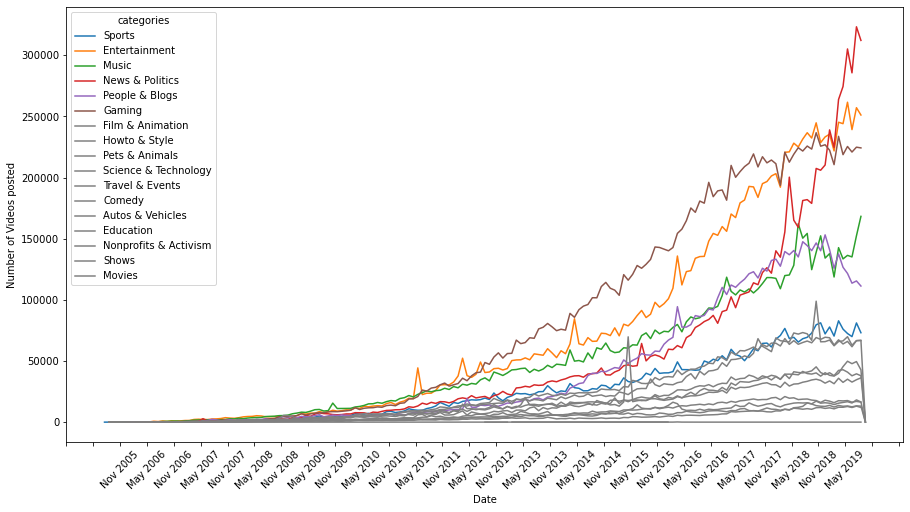

In [7]:
plot_comparison(video_evolution_pd)

<div class="alert alert-block alert-info">
    <p>
    We can see that the number of videos on Youtube has exploded over the given time period </p>
    <p>
    The categories that have been growing the most are  News & Politics, Entertainemnt and Gaming, but Sports videos also had a nice increase over time
    </p>
 </div>

### Among these videos, what is the proportion of videos discussing sports? [*WORK IN PROGRESS*]

In [8]:
video_evolution_sports_pd = video_evolution_pd[video_evolution_pd["categories"].isin(["Sports"])]
video_evolution_sports_pd = video_evolution_sports_pd.drop(["year", "month"], axis=1).merge(
    video_evolution_pd.rename({"nb_videos": "total_nb_videos"}, axis=1), on=["date", "categories"]
)

video_evolution_sports_pd["nb_videos"] = video_evolution_sports_pd["nb_videos"].fillna(0)


video_evolution_sports_pd["percentage_sports_videos"] = video_evolution_sports_pd["nb_videos"] / video_evolution_sports_pd["total_nb_videos"]

In [9]:
video_evolution_sports_pd

,categories,nb_videos,date,year,month,total_nb_videos,percentage_sports_videos
0,Sports,1,2005-05-01,2005,5,1,1.0
1,Sports,1,2005-10-01,2005,10,1,1.0
2,Sports,1,2005-11-01,2005,11,1,1.0
3,Sports,3,2006-01-01,2006,1,3,1.0
4,Sports,10,2006-02-01,2006,2,10,1.0
...,...,...,...,...,...,...,...
162,Sports,76056,2019-04-01,2019,4,76056,1.0
163,Sports,72488,2019-05-01,2019,5,72488,1.0
164,Sports,69933,2019-06-01,2019,6,69933,1.0
165,Sports,81114,2019-07-01,2019,7,81114,1.0


## How did the popularity of NBA videos evolve over the same time period ?

,year_month,view_count
0,2006-02-01,24969.0
1,2006-04-01,488786.0
2,2006-05-01,18929.0
3,2006-06-01,354736.0
4,2006-07-01,52842.0
...,...,...
159,2019-06-01,600375318.0
160,2019-07-01,448507408.0
161,2019-08-01,316718569.0
162,2019-09-01,223002395.0


<AxesSubplot:title={'center':'Yotube views for NBA evolution over time'}, xlabel='Date', ylabel='Views (in Millions)'>

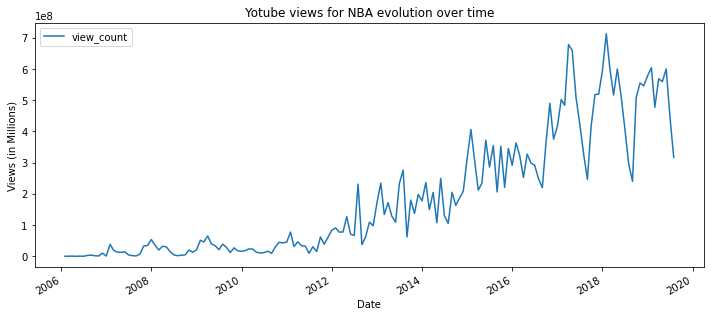

In [10]:
required_tags = ["nba", "basketball"]

video_metadata_df_sports = video_metadata_df[video_metadata_df["categories"].isin(["Sports"])]
video_metadata_df_sports["tags"] = video_metadata_df_sports["tags"].str.lower()
video_metadata_df_sports["tags"] = video_metadata_df_sports["tags"].apply(lambda x: f",{x},")

nba_basketball_df = video_metadata_df_sports[video_metadata_df_sports["tags"].str.contains(f',{",|,".join(required_tags)},')].persist()
nba_basketball_df["year_month"] = dd.to_datetime(
    nba_basketball_df.upload_date.dt.year.astype("str") + "-" + nba_basketball_df.upload_date.dt.month.astype("str")
)

video_evolution_views = (
    nba_basketball_df[["year_month", "view_count"]].groupby(by="year_month").sum().persist()
)  # we persist the result from dask here in order to avoid recomputing the values in the future
video_evolution_views_pd = video_evolution_views.compute()

video_evolution_views_pd.sort_index(inplace=True)  # sort values by month and year in order to show them on a plot over time
video_evolution_views_pd.reset_index(inplace=True)

video_evolution_views_pd["year_month"] = pd.to_datetime(video_evolution_views_pd["year_month"])
display(video_evolution_views_pd)
video_evolution_views_pd = video_evolution_views_pd[video_evolution_views_pd.year_month < "09-2019"]  # filter out all results after September 2019

video_evolution_views_pd.plot(
    x="year_month", y="view_count", title="Yotube views for NBA evolution over time", xlabel="Date", ylabel="Views (in Millions)", figsize=(12, 5)
)

<div class="alert alert-block alert-info">
    <p>
        The overall popularity in terms of views for <b>NBA</b> on youtube has been constantly rising over the years </p>
    <p>
    We can however notice a certain cyclicality every year. This is because during the off-season, when no games are played, less videos about <b>NBA</b> are posted
    </p>
 </div>

In [11]:
video_metadata_df.head()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
0,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:26.270363,Lego City Police Lego Firetruck Cartoons about...,1.0,SBqSc91Hn9g,1159,8.0,"lego city,lego police,lego city police,lego ci...",Lego City Police Lego Firetruck Cartoons about...,2016-09-28,1057
1,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:26.914516,Lego Marvel SuperHeroes Lego Hulk Smash Iron-M...,1.0,UuugEl86ESY,2681,23.0,"Lego superheroes,lego hulk,hulk smash,lego mar...",Lego Marvel SuperHeroes Lego Hulk Smash Iron-M...,2016-09-28,12894
2,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:26.531203,Lego City Police Lego Fireman Cartoons about L...,779.0,oB4c-yvnbjs,1394,1607.0,"lego city,lego police,lego city police,lego fi...",Lego City Police Lego Fireman Cartoons about L...,2016-09-28,1800602
3,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:28.335329,Lego Harry Potter Complete Lego New Movie for ...,24.0,ZaV-gTCMV8E,5064,227.0,"Lego harry potter,new harry potter,harry potte...",Lego Harry Potter Complete Lego New Movie for ...,2016-09-28,57640
4,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:30.328487,Lego City Police LONG VIDEO for kids Lego Fire...,13.0,cGvL7AvMfM0,3554,105.0,"lego city,lego police,lego city police,lego fi...",Lego City Police 1 HOUR LONG VIDEO for kids Le...,2016-09-28,86368


### Are Basketball (NBA) videos more liked or disliked than other sports? [*WORK IN PROGRESS*]

In [ ]:
video_metadata_df_sports = video_metadata_df[video_metadata_df["categories"] == "Sports"]
video_metadata_df_sports["tags"] = video_metadata_df_sports["tags"].apply(lambda x: f",{x},")

basketball_df = video_metadata_df_sports[video_metadata_df_sports["tags"].str.contains(",basketball,")].persist()

baseball_df = video_metadata_df_sports[video_metadata_df_sports["tags"].str.contains("baseball")].persist()

hockey_df = video_metadata_df_sports[video_metadata_df_sports["tags"].str.contains("hockey")].persist()

football_df = video_metadata_df_sports[video_metadata_df_sports["tags"].str.contains("american football")].persist()

In [13]:
video_metadata_df_sports["tags"].str.contains(",basketball,").head()

1292    False
1293    False
1294    False
1295    False
1296    False
Name: tags, dtype: bool